In [4]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import sys 
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from cartopy.io.img_tiles import OSM
import matplotlib.pyplot as plt
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
sys.path.append('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/atmos')
from inventories.gra2pes import gra2pes_utils as gu
from inventories.gra2pes import gra2pes_config 



#from lair.air import inventories
#from lair.utils.geo import PC, bbox2extent
#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# James LAIR

In [2]:
# SLV CH4 Point Sources

from shapely.geometry import Point

from lair.utils.geo import PC


locations = {  # Satellite imagery center point
    'landfill': {
        'Salt Lake':    Point(-112.043, 40.746),
        'Trans-Jordan': Point(-112.055, 40.558),
        'Bountiful':    Point(-111.917, 40.911)},
    'refinery': {  # EPA 2011 ICR mean location by facility name
        'Chevron':        Point(-111.924, 40.825),
        'Big West Oil':   Point(-111.920, 40.838),
        'Marathon':       Point(-111.909, 40.794),
        'Holly Refining': Point(-111.904, 40.887),
        'Silver Eagle':   Point(-111.910, 40.868)},
    'wastewater': {
        'Magna Water & Sewer District':            Point(-112.074, 40.728),
        'Central Valley Water Reclamation':        Point(-111.900, 40.682),
        'Jordan Basin Water Reclamation Facility': Point(-111.919, 40.504),
        'SLC Water Reclamation Facility':          Point(-111.931, 40.813),
        'So. Valley Water Reclamation':            Point(-111.924, 40.615),
        'South Davis Sewer District-South Plant':  Point(-111.942, 40.842),
        'South Davis Sewer District-North Plant':  Point(-111.933, 40.903),
        'Central Davis Co Sewer':                  Point(-111.945, 41.001)}
}

markers = {
    'landfill': 's',
    'refinery': '^',
    'wastewater': 'o'
}

def plot_point_sources(kind, ax):
    for source, point in locations[kind].items():
        ax.scatter(point.x, point.y, transform=PC,
                   label=source, c='black',
                   marker=markers[kind])

    return ax

In [3]:
# Load inventories
ch4_inventories = {
    'EDGARv8':   inventories.EDGARv8('CH4'),
    'EPAv1':     inventories.EPAv1(),
    'EPAv2':     inventories.EPAv2(),
    'GFEIv2':    inventories.GFEIv2(),
    'WetCHARTs': inventories.WetCHARTs(),
}

In [4]:
SLV_bounds = (-112.1, 40.5,
              -111.8, 41.0)

# Clip to SLV bounds and get extent
clip_bounds = (SLV_bounds[0] - 0.1, SLV_bounds[1] - 0.1,
               SLV_bounds[2] + 0.1, SLV_bounds[3] + 0.1)
ch4_inventories = {name: inventory.clip(clip_bounds)
                   for name, inventory in ch4_inventories.items()}
extent = bbox2extent(SLV_bounds)

In [5]:
# Determine vmax for colorbar
vmax = float(max(inventory.total_emissions.max()
                 for inventory in ch4_inventories.values()))

In [8]:
# Get background tiles
tiler = OSM()
tiler_zoom = 9

In [9]:
# Figure options
cmap = 'Reds'
alpha = 0.75

In [ ]:
# Plot
fig, axes = plt.subplots(ncols=len(ch4_inventories), sharey=True,
                         figsize=(15, 5),
                         subplot_kw={'projection': tiler.crs})

i = 1
for ax, (name, inventory) in zip(axes.flatten(), ch4_inventories.items()):
    ax.set_extent(extent, crs=PC)
    ax.add_image(tiler, tiler_zoom)

    # Add colorbar
    if i == len(ch4_inventories):
        add_colorbar = True
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.825, axes[0].get_position().y0,
                                0.05, axes[0].get_position().height])
    else:
        add_colorbar = False
        cbar_ax = None

    # Filter data to last year
    year = inventory.data.time.dt.year.values[-1]  # Last year
    data = inventory.total_emissions.sel(time=str(year)).mean(dim='time')

    # Plot inventory
    data.plot(ax=ax, transform=PC,
              cmap=cmap, alpha=alpha,
              vmin=0, vmax=vmax,
              add_colorbar=add_colorbar, cbar_ax=cbar_ax)

    # Plot point sources
    plot_point_sources('landfill', ax)
    plot_point_sources('refinery', ax)
    
    ax.set(title=f'{name}\n{year}',
           xlabel=None, ylabel=None)

    i += 1

In [ ]:

import matplotlib.pyplot as plt
from lair.air import inventories

plt.figure()
i = inventories.EPAv2()
i.clip([-112.2, 40.05, -111.2, 41], crs=4326)
data = i.total_emissions.mean('time')
integrated = i.integrate().isel(time=-1)
data.plot()
print(f'Original Dimensions: lat={data.lat.size}, lon={data.lon.size}')
print(f'Original Total = {float(integrated)}')


plt.figure()
i.resample(0.2)
resampled = i.total_emissions.mean('time')
integrated = i.integrate().isel(time=-1)
resampled.plot()
print(f'Resampled Dimensions: lat={resampled.lat.size}, lon={resampled.lon.size}')
print(f'Resampled Total = {float(integrated)}')

# Derek Vulcan

In [2]:
def load_convert_times(nc_path,lat_bounds,lon_bounds):
    ds = xr.open_dataset(nc_path,decode_times = False)
    ds['time'] = pd.to_datetime(ds['time'].values,unit = 's')
    #ds = slice_latlon(ds, lat_bounds, lon_bounds)
    return ds
    
def slice_latlon(ds, lat_bounds, lon_bounds):
    return ds.sel(lat = slice(*lat_bounds), lon = slice(*lon_bounds))

## First try with stuff in "scripts" folder

In [4]:
prior_2019 = load_convert_times('/uufs/chpc.utah.edu/common/home/lin-group9/agm/inventories/Mallia_SLC/scripts/prior_emiss_2019.nc')
posterior_2019 = load_convert_times('/uufs/chpc.utah.edu/common/home/lin-group9/agm/inventories/Mallia_SLC/scripts/post_emiss_2019.nc')
prior_2020 = load_convert_times('/uufs/chpc.utah.edu/common/home/lin-group9/agm/inventories/Mallia_SLC/scripts/prior_emiss_2020.nc')
posterior_2020 = load_convert_times('/uufs/chpc.utah.edu/common/home/lin-group9/agm/inventories/Mallia_SLC/scripts/post_emiss_2020.nc')

In [5]:
prior_2019_timedf = prior_2019['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'prior_2019'})
posterior_2019_timedf = posterior_2019['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'posterior_2019'})
timedf_2019 = pd.concat([prior_2019_timedf,posterior_2019_timedf],axis = 1)

prior_2020_timedf = prior_2020['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'prior_2020'})
posterior_2020_timedf = posterior_2020['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'posterior_2020'})
timedf_2020 = pd.concat([prior_2020_timedf,posterior_2020_timedf],axis = 1)

In [ ]:
# Create subplots with shared y-axes
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.05)

# Add traces for 2019
fig.add_trace(go.Scatter(
    x=timedf_2019.index,
    y=timedf_2019['prior_2019'],
    mode='lines',
    name='Prior 2019'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=timedf_2019.index,
    y=timedf_2019['posterior_2019'],
    mode='lines',
    name='Posterior 2019'
), row=1, col=1)

# Add traces for 2020
fig.add_trace(go.Scatter(
    x=timedf_2020.index,
    y=timedf_2020['prior_2020'],
    mode='lines',
    name='Prior 2020'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=timedf_2020.index,
    y=timedf_2020['posterior_2020'],
    mode='lines',
    name='Posterior 2020'
), row=1, col=2)

# Define common tick values and labels
common_ticks = ['2019-03-01', '2019-04-01','2019-05-01', '2020-03-01','2020-04-01', '2020-05-01']
common_labels = ['Mar 2019', 'Apr 2019', 'May 2019', 'Mar 2020', 'Apr 2020', 'May 2020']

# Update layout
fig.update_layout(
    yaxis_title='Sum of Gridcell Emissions (umol/s)/gca',
    xaxis=dict(
        title='2019',
        tickvals=common_ticks[:3],
        ticktext=common_labels[:3],
        showgrid=True
    ),
    xaxis2=dict(
        title='2020',
        tickvals=common_ticks[3:],
        ticktext=common_labels[3:],
        showgrid=True
    )
)

fig.show()

### 2019

In [15]:
diff_2019 = posterior_2019-prior_2019
afternoon_diff_2019 = diff_2019.sel(  time = (diff_2019['time'].dt.hour.isin([18,19,20,21,22,23,0])) & 
                                        (diff_2019['time'].dt.month.isin([3,4]))  
                                    ).mean('time')
afternoon_diff_2019['emiss'].attrs['units'] = 'emission_diff'

perc_diff_2019 = (posterior_2019-prior_2019)/prior_2019
afternoon_perc_diff_2019 = perc_diff_2019.sel(  time = (diff_2019['time'].dt.hour.isin([18,19,20,21,22,23,0])) & 
                                        (diff_2019['time'].dt.month.isin([3,4]))  
                                    ).mean('time')
afternoon_perc_diff_2019['emiss'].attrs['units'] = 'emission_perc_diff'


In [ ]:
map_extent={'lon_min':-112.2,
        'lon_max':-111.55,
        'lat_min':40.3,
        'lat_max':41.1} 

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)

diff_plot = afternoon_diff_2019['emiss'].plot(ax=ax,transform=proj,cmap = 'coolwarm',vmin=-20,vmax = 20,alpha = 0.8)

request = cimgt.GoogleTiles(style='street')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))

plt.show()

In [ ]:
map_extent={'lon_min':-112.2,
        'lon_max':-111.55,
        'lat_min':40.3,
        'lat_max':41.1} 

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)

diff_plot = afternoon_perc_diff_2019['emiss'].plot(ax=ax,transform=proj,cmap = 'Purples_r',vmin=-0.1,vmax = -0.4,alpha = 0.8)

request = cimgt.GoogleTiles(style='street')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))

plt.show()

## Second try with stuff in "inversion_inputs" folder

In [18]:
prior_2019 = load_convert_times('/uufs/chpc.utah.edu/common/home/lin-group9/agm/inventories/Mallia_SLC/inversion_inputs/prior_emiss_2019.nc')
prior_2020 = load_convert_times('/uufs/chpc.utah.edu/common/home/lin-group9/agm/inventories/Mallia_SLC/inversion_inputs/prior_emiss_2020.nc')


In [25]:
prior_2019_timedf = prior_2019['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'prior_2019'})
#posterior_2019_timedf = posterior_2019['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'posterior_2019'})
timedf_2019 =  pd.concat([prior_2019_timedf,posterior_2019_timedf],axis = 1)

prior_2020_timedf = prior_2020['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'prior_2020'})
#posterior_2020_timedf = posterior_2020['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'posterior_2020'})
timedf_2020 = pd.concat([prior_2020_timedf,posterior_2020_timedf],axis = 1)

In [ ]:
# Create subplots with shared y-axes
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.05)

# Add traces for 2019
fig.add_trace(go.Scatter(
    x=timedf_2019.index,
    y=timedf_2019['prior_2019'],
    mode='lines',
    name='Prior 2019'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=timedf_2019.index,
    y=timedf_2019['posterior_2019'],
    mode='lines',
    name='Posterior 2019'
), row=1, col=1)

# Add traces for 2020
fig.add_trace(go.Scatter(
    x=timedf_2020.index,
    y=timedf_2020['prior_2020'],
    mode='lines',
    name='Prior 2020'
), row=1, col=2)

# fig.add_trace(go.Scatter(
#     x=timedf_2020.index,
#     y=timedf_2020['posterior_2020'],
#     mode='lines',
#     name='Posterior 2020'
# ), row=1, col=2)

# Define common tick values and labels
common_ticks = ['2019-03-01', '2019-04-01','2019-05-01', '2020-03-01','2020-04-01', '2020-05-01']
common_labels = ['Mar 2019', 'Apr 2019', 'May 2019', 'Mar 2020', 'Apr 2020', 'May 2020']

# Update layout
fig.update_layout(
    yaxis_title='Sum of Gridcell Emissions (umol/s)/gca',
    xaxis=dict(
        title='2019',
        tickvals=common_ticks[:3],
        ticktext=common_labels[:3],
        showgrid=True
    ),
    xaxis2=dict(
        title='2020',
        tickvals=common_ticks[3:],
        ticktext=common_labels[3:],
        showgrid=True
    )
)

fig.show()

## Files taken from "emiss_inventories/scaled_vulcan" folder

In [3]:
lat_bounds = [40.4, 41]
lon_bounds = [-112.15, -111.73] 
base_dir = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/inventories/Mallia_SLC/emiss_inventories_scaled_vulcan/'

prior_2019_fname = 'vulcan_gsv_emiss_2019_V1.nc'
prior_2019 = load_convert_times(os.path.join(base_dir,prior_2019_fname),lat_bounds,lon_bounds)

posterior_2019_fname = 'vulcan_gsv_emiss_2019_inv-updated_noDT.nc'
posterior_2019 = load_convert_times(os.path.join(base_dir,posterior_2019_fname),lat_bounds,lon_bounds)

prior_2020_fname = 'vulcan_gsv_emiss_2020_inv-updated_noDT.nc'
prior_2020 = load_convert_times(os.path.join(base_dir,prior_2020_fname),lat_bounds,lon_bounds)

posterior_2020_fname = 'vulcan_gsv_emiss_2020_covid-adjusted.nc'
posterior_2020 = load_convert_times(os.path.join(base_dir,posterior_2020_fname),lat_bounds,lon_bounds)

In [ ]:
posterior_2020

In [5]:
posterior_2019 = posterior_2019.sel(time=slice('2019-03-01','2019-04-30'))
posterior_2019['emiss'].attrs['long_name'] = 'Posterior 2019'

prior_2020 = prior_2020.sel(time=slice('2020-03-15','2020-04-30'))
prior_2020['emiss'].attrs['long_name'] = 'Prior 2020'

posterior_2020 = posterior_2020.sel(time=slice('2020-03-15','2020-04-30'))
posterior_2020['emiss'].attrs['long_name'] = 'Posterior 2020'

In [7]:
prior_2019.to_netcdf('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC/for_haley/prior_2019.nc')
posterior_2019.to_netcdf('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC/for_haley/posterior_2019.nc')
prior_2020.to_netcdf('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC/for_haley/prior_2020.nc')
posterior_2020.to_netcdf('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC/for_haley/posterior_2020.nc')

In [4]:
prior_2019_timedf = prior_2019['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'prior_2019'})
posterior_2019_timedf = posterior_2019['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'posterior_2019'})
timedf_2019 = pd.concat([prior_2019_timedf,posterior_2019_timedf],axis = 1)

prior_2020_timedf = prior_2020['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'prior_2020'})
posterior_2020_timedf = posterior_2020['emiss'].sum(dim = ['lat','lon']).to_dataframe().rename(columns = {'emiss':'posterior_2020'})
timedf_2020 = pd.concat([prior_2020_timedf,posterior_2020_timedf],axis = 1)

spring_timedf_2019 = timedf_2019.loc[(timedf_2019.index >= '2019-03-01') & (timedf_2019.index <= '2019-04-30')]
spring_timedf_2020 = timedf_2020.loc[(timedf_2020.index >= '2020-03-15') & (timedf_2020.index <= '2020-04-30')]

#### Full  timeseries

In [ ]:
# Create subplots with shared y-axes
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.05)

# Add traces for 2019
fig.add_trace(go.Scatter(
    x=timedf_2019.index,
    y=timedf_2019['prior_2019'],
    mode='lines',
    name='Prior 2019'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=timedf_2019.index,
    y=timedf_2019['posterior_2019'],
    mode='lines',
    name='Posterior 2019'
), row=1, col=1)

# Add traces for 2020
fig.add_trace(go.Scatter(
    x=timedf_2020.index,
    y=timedf_2020['prior_2020'],
    mode='lines',
    name='Prior 2020'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=timedf_2020.index,
    y=timedf_2020['posterior_2020'],
    mode='lines',
    name='Posterior 2020'
), row=1, col=2)

# Define common tick values and labels
common_ticks = pd.date_range(start='2019-01-01', end='2020-12-31', freq='MS').strftime('%Y-%m-%d').tolist()
common_labels = pd.date_range(start='2019-01-01', end='2020-12-31', freq='MS').strftime('%b %Y').tolist()

# Update layout
fig.update_layout(
    yaxis_title='Sum of Gridcell Emissions (umol/s)/gca',
    xaxis=dict(
        title='2019',
        tickvals=common_ticks[:12],
        ticktext=common_labels[:12],
        showgrid=True
    ),
    xaxis2=dict(
        title='2020',
        tickvals=common_ticks[12:],
        ticktext=common_labels[12:],
        showgrid=True
    )
)

fig.show()

#### Spring timeseries

In [ ]:
# Create subplots with shared y-axes
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.05)

# Add traces for 2019
fig.add_trace(go.Scatter(
    x=spring_timedf_2019.index,
    y=spring_timedf_2019['prior_2019'],
    mode='lines',
    name='Prior 2019'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=spring_timedf_2019.index,
    y=spring_timedf_2019['posterior_2019'],
    mode='lines',
    name='Posterior 2019'
), row=1, col=1)

# Add traces for 2020
fig.add_trace(go.Scatter(
    x=spring_timedf_2020.index,
    y=spring_timedf_2020['prior_2020'],
    mode='lines',
    name='Prior 2020'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=spring_timedf_2020.index,
    y=spring_timedf_2020['posterior_2020'],
    mode='lines',
    name='Posterior 2020'
), row=1, col=2)

# Define common tick values and labels
common_ticks = pd.date_range(start='2019-01-01', end='2020-12-31', freq='MS').strftime('%Y-%m-%d').tolist()
common_labels = pd.date_range(start='2019-01-01', end='2020-12-31', freq='MS').strftime('%b %Y').tolist()

# Update layout
fig.update_layout(
    yaxis_title='Sum of Gridcell Emissions (umol/s)/gca',)
#     xaxis=dict(
#         title='2019',
#         tickvals=common_ticks[:12],
#         ticktext=common_labels[:12],
#         showgrid=True
#     ),
#     xaxis2=dict(
#         title='2020',
#         tickvals=common_ticks[12:],
#         ticktext=common_labels[12:],
#         showgrid=True
#     )
# )

fig.show()

In [ ]:
posterior_2019_ave = posterior_2019.mean('time')
map_extent = {'lon_min': -112.2, 'lon_max': -111.55, 'lat_min': 40.3, 'lat_max': 41.1}
labsize = 12
proj = ccrs.PlateCarree()

# Create a figure with two subplots side by side
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': proj})

# Plot the first map
ax1.set_extent([map_extent['lon_min'], map_extent['lon_max'], map_extent['lat_min'], map_extent['lat_max']], crs=proj)
diff_plot1 = posterior_2019_ave['emiss'].plot(ax=ax1, transform=proj, cmap='Reds', vmax = 100,alpha=0.8)
request = cimgt.GoogleTiles(style='street')
scale = 10.0
ax1.add_image(request, int(scale))

plt.show()

### 2019 Differences

In [14]:
diff_2019 = posterior_2019-prior_2019
afternoon_diff_2019 = diff_2019.sel(  time = (diff_2019['time'].dt.hour.isin([18,19,20,21,22,23,0])) & 
                                        (diff_2019['time'].dt.month.isin([3,4]))  
                                    ).mean('time')
afternoon_diff_2019['emiss'].attrs['units'] = 'emission_diff'

perc_diff_2019 = (posterior_2019-prior_2019)/prior_2019
afternoon_perc_diff_2019 = perc_diff_2019.sel(  time = (perc_diff_2019['time'].dt.hour.isin([18,19,20,21,22,23,0])) & 
                                        (perc_diff_2019['time'].dt.month.isin([3,4]))  
                                    ).mean('time')
afternoon_perc_diff_2019['emiss'].attrs['units'] = 'emission_perc_diff'


In [ ]:
map_extent = {'lon_min': -112.2, 'lon_max': -111.55, 'lat_min': 40.3, 'lat_max': 41.1}
labsize = 12
proj = ccrs.PlateCarree()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': proj})

# Plot the first map
ax1.set_extent([map_extent['lon_min'], map_extent['lon_max'], map_extent['lat_min'], map_extent['lat_max']], crs=proj)
diff_plot1 = afternoon_diff_2019['emiss'].plot(ax=ax1, transform=proj, cmap='coolwarm', vmin=-20, vmax=20, alpha=0.8)
request = cimgt.GoogleTiles(style='street')
scale = 10.0
ax1.add_image(request, int(scale))

# Plot the second map
ax2.set_extent([map_extent['lon_min'], map_extent['lon_max'], map_extent['lat_min'], map_extent['lat_max']], crs=proj)
diff_plot2 = afternoon_perc_diff_2019['emiss'].plot(ax=ax2, transform=proj, cmap='Purples_r', vmin=-0.1, vmax=-0.4, alpha=0.8)
ax2.add_image(request, int(scale))

plt.show()

### 2020

In [30]:
diff_2020 = posterior_2020-prior_2020
afternoon_diff_2020 = diff_2020.sel(  time = (diff_2020['time'].dt.hour.isin([18,19,20,21,22,23,0])) & 
                                        (diff_2020['time'].dt.month.isin([3,4]))  
                                    ).mean('time')
afternoon_diff_2020['emiss'].attrs['units'] = 'emission_diff'

perc_diff_2020 = (posterior_2020-prior_2020)/prior_2020
afternoon_perc_diff_2020= perc_diff_2020.sel(  time = (perc_diff_2020['time'].dt.hour.isin([18,19,20,21,22,23,0])) & 
                                        (perc_diff_2020['time'].dt.month.isin([3,4]))  
                                    ).mean('time')
afternoon_perc_diff_2020['emiss'].attrs['units'] = 'emission_perc_diff'


In [ ]:
map_extent = {'lon_min': -112.2, 'lon_max': -111.55, 'lat_min': 40.3, 'lat_max': 41.1}
labsize = 12
proj = ccrs.PlateCarree()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': proj})

# Plot the first map
ax1.set_extent([map_extent['lon_min'], map_extent['lon_max'], map_extent['lat_min'], map_extent['lat_max']], crs=proj)
diff_plot1 = afternoon_diff_2020['emiss'].plot(ax=ax1, transform=proj, cmap='coolwarm', vmin=-10, vmax=10, alpha=0.8)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0
ax1.add_image(request, int(scale))

# Plot the second map
ax2.set_extent([map_extent['lon_min'], map_extent['lon_max'], map_extent['lat_min'], map_extent['lat_max']], crs=proj)
diff_plot2 = afternoon_perc_diff_2020['emiss'].plot(ax=ax2, transform=proj, cmap='Purples_r', vmin=-0.05, vmax=-0.25, alpha=0.8)
ax2.add_image(request, int(scale))

plt.show()

# GRA2PES

In [25]:
config = gra2pes_config.Gra2pesConfig()
extra_ids = 'methane'
specs = ['CO2','HC01']

BGH = gu.BaseGra2pesHandler(config,specs = specs, extra_ids = extra_ids)

sector = 'ONROAD_GAS'
year = 2021
month = 6
day_type = 'weekdy'
ds = BGH.load_fmt_fullday(sector, year, month, day_type, check_extra=False)
#ds


In [26]:
regrid_config = gra2pes_config.Gra2pesRegridConfig()
grapes_regridder = gu.Gra2pesRegridder(regrid_config)
regridded_ds = grapes_regridder.regrid(ds)

Creating regridder


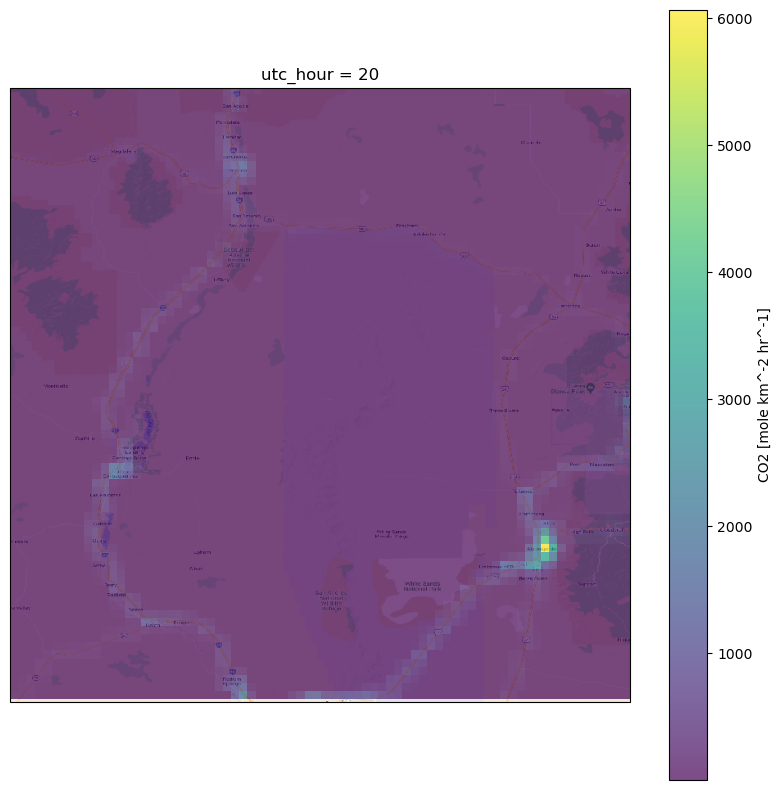

In [30]:
utc_hour = 20
bottom_top = 0
spec = 'CO2'

# map_extent={'lon_min':-112.2,
#         'lon_max':-111.55,
#         'lat_min':40.3,
#         'lat_max':41.1} 
map_extent={'lon_min':-107.59,
            'lon_max':-105.69,
            'lat_min':32.430,
            'lat_max':34.31} 


cropped_ds = regridded_ds.sel(lat=slice(map_extent['lat_min'],map_extent['lat_max']), 
                              lon=slice(map_extent['lon_min'],map_extent['lon_max']),
                              bottom_top = bottom_top)

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)

request = cimgt.GoogleTiles(style='street')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))

cropped_ds.sel({'utc_hour':utc_hour})[spec].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis',alpha = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

In [15]:
ds['HC01'].sum().values

array(1.0833103e+08, dtype=float32)

In [17]:
regridded_ds['HC01'].sum().values

array(2.9033878e+08, dtype=float32)